In [ ]:
!nvidia-smi || echo "No GPU visible (OK for Day-1)."
!pip -q install scikit-learn opencv-python tqdm

Fri Sep 12 14:31:35 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   45C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [18]:
!pip install streamlit pyngrok

In [15]:
import os
from pathlib import Path
import random
import sys
import numpy as np
import time
from typing import Dict, Tuple
from types import SimpleNamespace

import torch
import torch.nn as nn
from sklearn.metrics import f1_score

import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from collections import defaultdict


In [ ]:
DRIVE_SAVE_DIR = Path("/content/drive/MyDrive/crop-disease-detector/models")
DRIVE_SAVE_DIR.mkdir(parents=True, exist_ok=True)

In [ ]:
BASE = "/content/drive/MyDrive/crop-disease-detector"
for p in ["data","src","models","app","docs"]:
    os.makedirs(f"{BASE}/{p}", exist_ok=True)

print("Folders ready at:", BASE)

Folders ready at: /content/drive/MyDrive/crop-disease-detector


In [ ]:
def copy_images(img_paths, dst_dir):
    dst_dir.mkdir(parents=True, exist_ok=True)
    for p in img_paths:
        shutil.copy2(p, dst_dir/p.name)

In [ ]:
def run_split(source, dest, train=0.7, val=0.15, seed=42, limit_per_class=0):
    random.seed(seed)
    src = Path(source)
    if not src.exists():
        raise FileNotFoundError(f"SOURCE does not exist: {src}")
    dst = Path(dest)
    (dst/"train").mkdir(parents=True, exist_ok=True)
    (dst/"val").mkdir(parents=True, exist_ok=True)
    (dst/"test").mkdir(parents=True, exist_ok=True)

    classes = [d for d in src.iterdir() if d.is_dir()]
    if not classes:
        raise RuntimeError(f"No class subfolders found in {src}")

    for c in classes:
        imgs = [p for p in c.iterdir() if p.suffix.lower() in [".jpg",".jpeg",".png"]]
        imgs.sort()
        if limit_per_class and len(imgs) > limit_per_class:
            imgs = random.sample(imgs, limit_per_class)

        random.shuffle(imgs)
        n = len(imgs)
        n_train = int(n * train)
        n_val   = int(n * val)
        train_set = imgs[:n_train]
        val_set   = imgs[n_train:n_train+n_val]
        test_set  = imgs[n_train+n_val:]

        copy_images(train_set, dst/"train"/c.name)
        copy_images(val_set,   dst/"val"/c.name)
        copy_images(test_set,  dst/"test"/c.name)

        print(f"{c.name}: total={n}  train={len(train_set)}  val={len(val_set)}  test={len(test_set)}")

In [ ]:
PROJECT_ROOT = Path("/Users/sameenmubashar/Desktop/Sameen/Automated-Phenotyping-for-Plant-Stress")
DATA_ROOT = PROJECT_ROOT / "data"

candidates = [p for p in DATA_ROOT.rglob("segmented") if p.is_dir()]
if not candidates:
  raise SystemExit(f"No 'segmented' folder found under {DATA_ROOT}. "
                         "Clone https://github.com/spMohanty/PlantVillage-Dataset.git "
                         "into data/raw_pv/")
SOURCE = str(candidates[0])
DEST = str(DATA_ROOT / "plantvillage")
print("Using SOURCE:", SOURCE)
print("Using DEST:  ", DEST)

run_split(SOURCE, DEST, train=0.70, val=0.15, seed=42, limit_per_class=0)

SystemExit: No 'segmented' folder found under /Users/sameenmubashar/Desktop/Sameen/Automated-Phenotyping-for-Plant-Stress/data. Clone https://github.com/spMohanty/PlantVillage-Dataset.git into data/raw_pv/

/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
def _find_dataset_root():
    """
    Directly use the train/val/test dataset on Google Drive.
    Update DRIVE_PATH to match mounted folder structure.
    """
    DRIVE_PATH = Path("/content/drive/MyDrive/crop-disease-detector/data/plantvillage/plantvillage")

    if DRIVE_PATH.is_dir():
        print(f"[auto] Using dataset root: {DRIVE_PATH}")
        return DRIVE_PATH

    sys.exit(
        f"Could not find dataset root at {DRIVE_PATH}. "
        "Make sure your Drive is mounted and path is correct."
    )

In [ ]:
IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".webp", ".tif", ".tiff"}

def _images_in_dir(d: Path):
    """Yield image paths inside directory d (non-recursive)."""
    for p in d.iterdir():
        if p.is_file() and p.suffix.lower() in IMG_EXTS:
            yield p

In [ ]:
def count_split(split: str, root_path: Path ):
    """
    Print per-class file counts for a given split (train/val/test).
      Looks under: <root_path>/<split>/<class>/*
    """
    root_local = root_path if root_path is not None else _find_dataset_root()
    base = root_local / split

    if not base.exists():
        print(f"== {split.upper()} == (missing at {base})")
        return

    class_dirs = [d for d in base.iterdir() if d.is_dir()]
    if not class_dirs:
        print(f"== {split.upper()} == (no class folders under {base})")
        return

    cls_counts = {d.name: sum(1 for _ in _images_in_dir(d)) for d in class_dirs}
    total = sum(cls_counts.values())

    print(f"== {split.upper()} ==")
    for k, v in sorted(cls_counts.items()):
        print(f"{k:35s} {v:5d}")
    print(f"TOTAL {split}: {total}\n")

In [ ]:
def show_grid(split: str, root: Path, samples_per_class: int = 1, max_classes: int = 8, cols: int | None = None):
    """
    Show a grid of sample images from the given split.
    Picks up to `max_classes` classes and `samples_per_class` images per class.
    """
    base = root / split
    if not base.exists():
        print(f"[warn] Split '{split}' not found at {base}")
        return

    classes = [d for d in base.iterdir() if d.is_dir()]
    if not classes:
        print(f"[warn] No class folders found under {base}")
        return

    random.shuffle(classes)
    classes = classes[:max_classes]

    images, titles = [], []
    for c in classes:
        files = [p for p in _images_in_dir(c)]
        if not files:
            continue
        random.shuffle(files)
        chosen = files[:samples_per_class]
        for p in chosen:
            try:
                images.append(Image.open(p).convert("RGB"))
                titles.append(c.name)
            except Exception as e:
                print(f"[warn] Could not open {p}: {e}")

    if not images:
        print("[warn] No images sampled to display.")
        return

    n = len(images)
    if cols is None:
        cols = min(4, n)
    rows = (n + cols - 1) // cols

    plt.figure(figsize=(3.5*cols, 3.5*rows))
    for idx, (img, title) in enumerate(zip(images, titles), start=1):
        ax = plt.subplot(rows, cols, idx)
        ax.imshow(img)
        ax.set_title(title, fontsize=10)
        ax.axis("off")
    plt.tight_layout()
    plt.show()

In [ ]:
from pathlib import Path

root = Path("/content/drive/MyDrive/crop-disease-detector/data/plantvillage/plantvillage")
print("Root exists?", root.exists(), root)

print("Children of root:")
for p in root.iterdir():
    print(" -", p.name, "(dir)" if p.is_dir() else "(file)")

for split in ["train", "val", "validation", "test"]:
    d = root / split
    print(f"\nSplit '{split}' exists? ", d.exists(), d)
    if d.exists():
        subs = [x for x in d.iterdir() if x.is_dir()]
        print(f"  #class folders under {split}: {len(subs)}")
        for s in subs[:5]:
            # list first few files in first few classes
            files = list(s.glob("*"))[:5]
            print("   ", s.name, "->", [f.name for f in files])

Root exists? True /content/drive/MyDrive/crop-disease-detector/data/plantvillage/plantvillage
Children of root:
 - test (dir)
 - train (dir)
 - val (dir)

Split 'train' exists?  True /content/drive/MyDrive/crop-disease-detector/data/plantvillage/plantvillage/train
  #class folders under train: 38
    Potato___Early_blight -> ['b549ab3b-06f1-45ef-bf34-86071552d870___RS_Early.B 8576_final_masked.jpg', '6bca5c10-8985-404c-96c3-3f77c2a77d10___RS_Early.B 7527_final_masked.jpg', 'eec2262a-d16b-42e1-99bd-6891ef392988___RS_Early.B 7085_final_masked.jpg', '05c35093-11b8-4cd0-b67a-148859754440___RS_Early.B 8939_final_masked.jpg', '911b9166-40ba-4dc8-974e-c916e6866142___RS_Early.B 9089_final_masked.jpg']
    Blueberry___healthy -> ['863f157f-f239-4402-9b58-98ca8e1c15d2___RS_HL 5134_final_masked.jpg', 'c04104d9-3762-4a52-969e-31867bbf63ca___RS_HL 2377_final_masked.jpg', 'fe97141f-556b-4f2f-bbd2-ef9b470c1b21___RS_HL 5460_final_masked.jpg', 'f50ea5c4-77ac-43f6-ba12-451b37c73cf8___RS_HL 0691_final_ma

== TRAIN ==
Apple___Apple_scab                      0
Apple___Black_rot                       0
Apple___Cedar_apple_rust                0
Apple___healthy                         0
Blueberry___healthy                  1051
Cherry_(including_sour)___Powdery_mildew     0
Cherry_(including_sour)___healthy       0
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot     0
Corn_(maize)___Common_rust_             0
Corn_(maize)___Northern_Leaf_Blight     0
Corn_(maize)___healthy                813
Grape___Black_rot                     826
Grape___Esca_(Black_Measles)            0
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)     0
Grape___healthy                         0
Orange___Haunglongbing_(Citrus_greening)     0
Peach___Bacterial_spot                  0
Peach___healthy                         0
Pepper,_bell___Bacterial_spot           0
Pepper,_bell___healthy                  0
Potato___Early_blight                 700
Potato___Late_blight                    0
Potato___healthy                

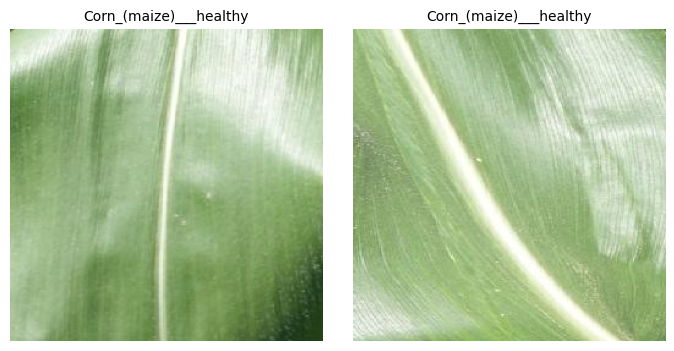

In [ ]:
root = Path("/content/drive/MyDrive/crop-disease-detector/data/plantvillage/plantvillage")

count_split("train", root)
count_split("val", root)
count_split("test", root)

show_grid("train", root, samples_per_class=2, max_classes=6)

In [ ]:
def seed_everything(seed: int = 42) -> None:
    """Set seeds for reproducibility."""
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # safe if no CUDA
    # For full determinism (can be slower):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [ ]:
def get_transforms(img_size: int = 224):
    """ImageNet-style preprocessing with light train-time aug."""
    mean = [0.485, 0.456, 0.406]
    std  = [0.229, 0.224, 0.225]

    train_tfms = transforms.Compose([
        transforms.RandomResizedCrop(img_size),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])

    eval_tfms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(img_size),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])
    return train_tfms, eval_tfms

In [ ]:
def get_dataloaders(
    data_root: str,
    batch_size: int = 64,
    num_workers: int = 2,
    img_size: int = 224,
    persistent_workers: bool = False,
) -> Tuple[DataLoader, DataLoader, DataLoader, Dict[str, int]]:
    """Create train/val/test dataloaders; return class_to_idx."""
    data_root = Path(data_root)
    if not (data_root / "train").exists():
        raise FileNotFoundError(f"Train dir not found: {data_root/'train'}")
    if not (data_root / "val").exists():
        raise FileNotFoundError(f"Val dir not found: {data_root/'val'}")
    if not (data_root / "test").exists():
        raise FileNotFoundError(f"Test dir not found: {data_root/'test'}")

    train_tfms, eval_tfms = get_transforms(img_size)

    train_ds = datasets.ImageFolder(data_root / "train", transform=train_tfms)
    val_ds   = datasets.ImageFolder(data_root / "val",   transform=eval_tfms)
    test_ds  = datasets.ImageFolder(data_root / "test",  transform=eval_tfms)

    pin = torch.cuda.is_available()
    train_dl = DataLoader(
        train_ds, batch_size=batch_size, shuffle=True,
        num_workers=num_workers, pin_memory=pin,
        persistent_workers=persistent_workers if num_workers > 0 else False,
    )
    val_dl = DataLoader(
        val_ds, batch_size=batch_size, shuffle=False,
        num_workers=num_workers, pin_memory=pin,
        persistent_workers=persistent_workers if num_workers > 0 else False,
    )
    test_dl = DataLoader(
        test_ds, batch_size=batch_size, shuffle=False,
        num_workers=num_workers, pin_memory=pin,
        persistent_workers=persistent_workers if num_workers > 0 else False,
    )
    return train_dl, val_dl, test_dl, train_ds.class_to_idx

In [ ]:
def build_model(arch: str, num_classes: int) -> nn.Module:
    """Create a pretrained model and replace classifier head; freeze backbone."""
    if arch == "mobilenetv2":
        weights = models.MobileNet_V2_Weights.IMAGENET1K_V1
        model = models.mobilenet_v2(weights=weights)
        in_feats = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(in_feats, num_classes)
        # Freeze feature extractor
        for p in model.features.parameters():
            p.requires_grad = False

    elif arch == "resnet50":
        weights = models.ResNet50_Weights.IMAGENET1K_V2
        model = models.resnet50(weights=weights)
        in_feats = model.fc.in_features
        model.fc = nn.Linear(in_feats, num_classes)
        # Freeze early/mid layers (train only the fc + layer4)
        for p in model.layer1.parameters(): p.requires_grad = False
        for p in model.layer2.parameters(): p.requires_grad = False
        for p in model.layer3.parameters(): p.requires_grad = False

    else:
        raise ValueError("arch must be 'mobilenetv2' or 'resnet50'")

    return model

In [ ]:
@torch.no_grad()
def evaluate(model: nn.Module, dl: DataLoader, device: torch.device) -> Tuple[float, list, list]:
    """Return (accuracy, y_true, y_pred)."""
    model.eval()
    correct, total = 0, 0
    y_true, y_pred = [], []
    for x, y in dl:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        preds = logits.argmax(1)
        correct += (preds == y).sum().item()
        total += y.size(0)
        y_true.extend(y.cpu().tolist())
        y_pred.extend(preds.cpu().tolist())
    acc = correct / max(total, 1)
    return acc, y_true, y_pred

In [ ]:
from tqdm.auto import tqdm

def train_one_epoch(model, dl, optimizer, criterion, device, amp=False) -> float:
    model.train()
    total_loss, total_items = 0.0, 0

    if amp and torch.cuda.is_available():
        scaler = torch.cuda.amp.GradScaler()
        for x, y in tqdm(dl, desc="train", leave=False):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad(set_to_none=True)
            with torch.cuda.amp.autocast():
                logits = model(x)
                loss = criterion(logits, y)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            total_loss += loss.item() * y.size(0)
            total_items += y.size(0)
    else:
        for x, y in tqdm(dl, desc="train", leave=False):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad(set_to_none=True)
            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * y.size(0)
            total_items += y.size(0)

    return total_loss / max(total_items, 1)

In [ ]:
def save_json(obj, path: Path):
    path.parent.mkdir(parents=True, exist_ok=True)
    with open(path, "w") as f:
        json.dump(obj, f, indent=2)

In [ ]:
def main(args):
    t0 = time.time()
    seed_everything(args.seed)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"[INFO] Device: {device}")

    train_dl, val_dl, test_dl, class_to_idx = get_dataloaders(
        data_root=args.data,
        batch_size=args.bs,
        num_workers=args.workers,
        img_size=args.img_size,
        persistent_workers=args.persistent_workers,
    )
    idx_to_class = {v: k for k, v in class_to_idx.items()}

    models_dir = Path("models")
    models_dir.mkdir(parents=True, exist_ok=True)
    save_json(idx_to_class, models_dir / "labels.json")

    model = build_model(args.arch, num_classes=len(class_to_idx)).to(device)

    trainable_params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.AdamW(trainable_params, lr=args.lr, weight_decay=args.weight_decay)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max(args.epochs, 1))
    criterion = nn.CrossEntropyLoss()

    best_val = 0.0
    best_path = models_dir / f"{args.arch}_best.pt"
    history = defaultdict(list)

    print(f"[INFO] Starting training for {args.epochs} epochs...")
    for epoch in range(args.epochs):
        train_loss = train_one_epoch(model, train_dl, optimizer, criterion, device, amp=args.amp)
        val_acc, _, _ = evaluate(model, val_dl, device)
        scheduler.step()

        history["train_loss"].append(train_loss)
        history["val_acc"].append(val_acc)

        print(f"Epoch {epoch+1:02d}/{args.epochs} | train_loss={train_loss:.4f} | val_acc={val_acc:.4f} | lr={scheduler.get_last_lr()[0]:.2e}")

        if val_acc > best_val:
            best_val = val_acc
            torch.save(model.state_dict(), best_path)
            _sync_best(best_path, args.arch)

    model.load_state_dict(torch.load(best_path, map_location=device))
    test_acc, y_true, y_pred = evaluate(model, test_dl, device)
    print(f"[RESULT] TEST ACCURACY: {test_acc:.4f}")

    report = classification_report(
        y_true, y_pred,
        target_names=[idx_to_class[i] for i in range(len(idx_to_class))],
        output_dict=True
    )
    print("\nClassification report (macro avg):")
    macro = report["macro avg"]
    print(f" precision={macro['precision']:.4f} recall={macro['recall']:.4f} f1={macro['f1-score']:.4f}")

    metrics = {
        "arch": args.arch,
        "img_size": args.img_size,
        "epochs": args.epochs,
        "batch_size": args.bs,
        "lr": args.lr,
        "best_val_acc": best_val,
        "test_acc": test_acc,
        "history": history,
        "classification_report": report,
    }
    save_json(metrics, models_dir / "metrics.json")

    elapsed = time.time() - t0
    print(f"[DONE] Elapsed: {elapsed/60:.1f} min. Best val_acc={best_val:.4f}. Checkpoints in {models_dir}.")

In [ ]:
import shutil, torch

data_path = "/content/plantvillage"
DRIVE_SAVE_DIR = Path("/content/drive/MyDrive/crop-disease-detector/models")
DRIVE_SAVE_DIR.mkdir(parents=True, exist_ok=True)

use_amp = torch.cuda.is_available()

num_workers = 4 if torch.cuda.is_available() else 2

args = SimpleNamespace(
    data=data_path,
    arch="mobilenetv2",
    epochs=8,
    bs=64 if torch.cuda.is_available() else 16,
    workers=num_workers,
    img_size=224,
    lr=3e-4,
    weight_decay=1e-4,
    seed=42,
    amp=use_amp,
    persistent_workers=bool(num_workers > 0),
)

if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True

def _sync_best(best_path, arch):
    DRIVE_SAVE_DIR.mkdir(parents=True, exist_ok=True)
    dst = DRIVE_SAVE_DIR / f"{arch}_best.pt"
    shutil.copy2(best_path, dst)
    print(f"[SYNC] Copied best checkpoint to Drive: {dst}")

main(args)



[INFO] Device: cpu
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 85.0MB/s]


[INFO] Starting training for 8 epochs...


KeyboardInterrupt: 

In [3]:
SEED = 42
random.seed(SEED); np.random.seed(SEED)
torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

Device: cpu


In [6]:

DATA_DIR   = "/content/plantvillage"
TRAIN_DIR  = f"{DATA_DIR}/train"
VAL_DIR    = f"{DATA_DIR}/val"

CKPT_PATH  = "/content/drive/MyDrive/crop-disease-detector/models/mobilenetv2_best.pt"

OUT_DIR    = "/content/day3_outputs"
CAM_DIR    = f"{OUT_DIR}/gradcam"
Path(OUT_DIR).mkdir(parents=True, exist_ok=True)
Path(CAM_DIR).mkdir(parents=True, exist_ok=True)

ARCH                 = "mobilenetv2"
EPOCHS               = 4
BATCH_SIZE           = 64
NUM_WORKERS          = 2
BASE_LR_UNFROZEN     = 1e-4
HEAD_LR              = 3e-4
WEIGHT_DECAY         = 1e-4

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

In [ ]:
train_tfms = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.6, 1.0), ratio=(0.9, 1.1)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.08, hue=0.02),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

val_tfms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

train_ds = datasets.ImageFolder(TRAIN_DIR, transform=train_tfms)
val_ds   = datasets.ImageFolder(VAL_DIR,   transform=val_tfms)

train_classes = train_ds.classes
num_classes   = len(train_classes)
print("Classes:", train_classes, "=>", num_classes)

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                      num_workers=NUM_WORKERS, pin_memory=True)
val_dl   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False,
                      num_workers=NUM_WORKERS, pin_memory=True)

In [ ]:
model = build_model(ARCH, num_classes).to(DEVICE)

def load_best_weights(model, ckpt_path):
    ckpt = torch.load(ckpt_path, map_location="cpu")
    if isinstance(ckpt, dict):
        for k in ["state_dict", "model_state_dict", "model"]:
            if k in ckpt and isinstance(ckpt[k], dict):
                ckpt = ckpt[k]
                break
    if isinstance(ckpt, dict):
        new_state = {k.replace("module.", ""): v for k, v in ckpt.items()}
        model.load_state_dict(new_state, strict=False)
    else:
        model = ckpt
    return model

model = load_best_weights(model, CKPT_PATH).to(DEVICE)
print("Loaded weights from:", CKPT_PATH)

def unfreeze_top_layers(m, arch, n_blocks=3):
    if arch == "mobilenetv2":
        assert isinstance(m, models.MobileNetV2)
        for p in m.classifier.parameters():
            p.requires_grad = True
        for p in m.features[-n_blocks:].parameters():
            p.requires_grad = True
    elif arch == "resnet50":
        for p in m.layer4.parameters():
            p.requires_grad = True
        for p in m.fc.parameters():
            p.requires_grad = True
    else:
        raise ValueError("Unsupported arch for unfreeze()")

unfreeze_top_layers(model, ARCH, n_blocks=3)

trainable = [n for n, p in model.named_parameters() if p.requires_grad]
print(f"Trainable param tensors: {len(trainable)}")

In [ ]:
from torch.optim.lr_scheduler import CosineAnnealingLR
def build_param_groups(m, arch, base_lr=BASE_LR_UNFROZEN, head_lr=HEAD_LR):
    if arch == "mobilenetv2":
        conv_params, head_params = [], []
        for name, p in m.named_parameters():
            if p.requires_grad:
                (head_params if name.startswith("classifier") else conv_params).append(p)
        return [
            {"params": conv_params, "lr": base_lr},
            {"params": head_params, "lr": head_lr},
        ]
    elif arch == "resnet50":
        conv_params, head_params = [], []
        for name, p in m.named_parameters():
            if p.requires_grad:
                (head_params if name.startswith("fc") else conv_params).append(p)
        return [
            {"params": conv_params, "lr": base_lr},
            {"params": head_params, "lr": head_lr},
        ]
    else:
        raise ValueError("Unsupported arch for param groups")

param_groups = build_param_groups(model, ARCH)
optimizer    = optim.AdamW(param_groups, weight_decay=WEIGHT_DECAY)
scheduler    = CosineAnnealingLR(optimizer, T_max=EPOCHS)
criterion    = nn.CrossEntropyLoss()
scaler       = torch.cuda.amp.GradScaler(enabled=(DEVICE.type=="cuda"))

print("Optimizer param groups:", [g["lr"] for g in optimizer.param_groups])

In [ ]:
from tqdm.notebook import tqdm

for epoch in range(1, EPOCHS + 1):
    t0 = time.time()
    print(f"\nEpoch {epoch}/{EPOCHS}")

    model.train(True)
    total_loss, y_true, y_pred = 0.0, [], []
    train_bar = tqdm(train_dl, desc="Train", leave=False)

    for images, targets in train_bar:
        images  = images.to(DEVICE, non_blocking=True)
        targets = targets.to(DEVICE, non_blocking=True)

        with torch.cuda.amp.autocast(enabled=(DEVICE.type=="cuda")):
            logits = model(images)
            loss   = criterion(logits, targets)

        optimizer.zero_grad(set_to_none=True)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item() * images.size(0)
        preds = logits.argmax(dim=1)
        y_true.append(targets.detach().cpu().numpy())
        y_pred.append(preds.detach().cpu().numpy())

        avg_loss = total_loss / ((len(y_true)) * BATCH_SIZE)
        train_bar.set_postfix(loss=f"{avg_loss:.4f}")

    y_true = np.concatenate(y_true); y_pred = np.concatenate(y_pred)
    train_loss = total_loss / len(train_dl.dataset)
    train_f1   = f1_score(y_true, y_pred, average="macro")

    model.train(False)
    total_loss, y_true, y_pred = 0.0, [], []
    val_bar = tqdm(val_dl, desc="Val", leave=False)

    with torch.no_grad():
        for images, targets in val_bar:
            images  = images.to(DEVICE, non_blocking=True)
            targets = targets.to(DEVICE, non_blocking=True)

            with torch.cuda.amp.autocast(enabled=(DEVICE.type=="cuda")):
                logits = model(images)
                loss   = criterion(logits, targets)

            total_loss += loss.item() * images.size(0)
            preds = logits.argmax(dim=1)
            y_true.append(targets.detach().cpu().numpy())
            y_pred.append(preds.detach().cpu().numpy())

            avg_loss = total_loss / ((len(y_true)) * BATCH_SIZE)
            val_bar.set_postfix(loss=f"{avg_loss:.4f}")

    y_true = np.concatenate(y_true); y_pred = np.concatenate(y_pred)
    val_loss = total_loss / len(val_dl.dataset)
    val_f1   = f1_score(y_true, y_pred, average="macro")

    scheduler.step()
    dt = time.time() - t0

    print(f"  train_loss {train_loss:.4f}  train_f1 {train_f1:.4f}  "
          f"| val_loss {val_loss:.4f}  val_f1 {val_f1:.4f}  "
          f"| {dt:.1f}s")

    if val_f1 > best_f1:
        best_f1 = val_f1
        save_checkpoint(model, BEST_PATH, train_classes, ARCH)
        print(f"  ↳ New best F1={best_f1:.4f}. Saved: {BEST_PATH}")

print("\nBest val F1 (macro):", best_f1)

In [ ]:
import torch.nn.functional as F
import numpy as np
from PIL import Image

ckpt = torch.load(BEST_PATH, map_location="cpu")
model.load_state_dict(ckpt["model_state_dict"], strict=False)
model.eval().to(DEVICE)

def pick_target_layers(m, arch):
    if arch == "mobilenetv2":
        return m.features[-1]
    elif arch == "resnet50":
        return m.layer4[-1]
    else:
        raise ValueError("Unsupported arch for Grad-CAM")

target_layer = pick_target_layers(model, ARCH)

class SimpleGradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None
        self.fwd_hook = target_layer.register_forward_hook(self._save_activation)
        self.bwd_hook = target_layer.register_full_backward_hook(self._save_gradient)

    def _save_activation(self, module, input, output):
        self.activations = output.detach()

    def _save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    @torch.no_grad()
    def _normalize_cam(self, cam_batch):
        cams = []
        for i in range(cam_batch.size(0)):
            c = cam_batch[i, 0]
            c = c - c.min()
            denom = (c.max() + 1e-8)
            c = c / denom
            cams.append(c.cpu().numpy())
        return np.stack(cams, axis=0)

    def __call__(self, input_tensor, class_idx=None):
        """
        input_tensor: (N,3,H,W), normalized
        class_idx:    None or (N,) tensor of target class ids
        returns:      np array (N,H,W) in [0,1]
        """
        logits = self.model(input_tensor)
        if class_idx is None:
            class_idx = logits.argmax(dim=1)

        self.model.zero_grad(set_to_none=True)
        loss = logits[torch.arange(logits.size(0)), class_idx].sum()
        loss.backward()

        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1, keepdim=True)
        cam = F.relu(cam)
        cam = F.interpolate(cam, size=input_tensor.shape[-2:], mode='bilinear', align_corners=False)
        return self._normalize_cam(cam)  # (N,H,W)

    def close(self):
        self.fwd_hook.remove()
        self.bwd_hook.remove()

inv_mean = torch.tensor(IMAGENET_MEAN).view(3,1,1)
inv_std  = torch.tensor(IMAGENET_STD).view(3,1,1)

def tensor_to_rgb01(img_tensor):
    img = img_tensor.detach().cpu() * inv_std + inv_mean
    img = img.clamp(0,1).permute(1,2,0).numpy().astype(np.float32)
    return img

def overlay_cam_on_image(rgb01, cam01, alpha=0.35):
    """
    rgb01: float32 HxWx3 in [0,1]
    cam01: float32 HxW in [0,1]
    returns uint8 HxWx3
    """
    cmap = plt.cm.jet(cam01)[..., :3]
    overlay = (1 - alpha) * rgb01 + alpha * cmap
    overlay = np.clip(overlay, 0, 1)
    return (overlay * 255).astype(np.uint8)

cam_engine = SimpleGradCAM(model, target_layer)
print("SimpleGradCAM ready.")

In [ ]:
N = min(8, len(val_ds))
idxs = np.random.choice(len(val_ds), size=N, replace=False)

for i, idx in enumerate(idxs):
    img_tensor, label = val_ds[idx]
    input_tensor = img_tensor.unsqueeze(0).to(DEVICE)

    cam01 = cam_engine(input_tensor)[0]
    rgb01 = tensor_to_rgb01(img_tensor)
    cam_img = overlay_cam_on_image(rgb01, cam01, alpha=0.35)

    label_name = train_classes[label]
    out_path = os.path.join(CAM_DIR, f"cam_{i:02d}_true-{label_name}.jpg")
    Image.fromarray(cam_img).save(out_path)

print(f"Saved {N} Grad-CAM overlays to: {CAM_DIR}")

In [8]:
import json
from pathlib import Path
from torchvision import datasets

data_root = Path("/content/drive/MyDrive/crop-disease-detector/data/plantvillagesplit")
train_ds = datasets.ImageFolder(data_root / "train")

class_to_idx = train_ds.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}

with open("labels.json", "w") as f:
    json.dump(idx_to_class, f, indent=2)

print("Saved labels.json with", len(idx_to_class), "classes")

Saved labels.json with 15 classes


In [47]:
from pyngrok import ngrok
public_url = ngrok.connect("8501")
public_url

<NgrokTunnel: "https://e3eac338c67f.ngrok-free.app" -> "http://localhost:8501">

Evaluating: 100%|██████████| 49/49 [03:57<00:00,  4.84s/batch]



✅ Test Accuracy: 0.9582

Classification Report:
                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.97      0.99      0.98       151
                     Pepper__bell___healthy       1.00      1.00      1.00       223
                      Potato___Early_blight       0.99      0.99      0.99       150
                       Potato___Late_blight       0.97      0.95      0.96       150
                           Potato___healthy       1.00      0.96      0.98        24
                      Tomato_Bacterial_spot       0.96      0.97      0.97       320
                        Tomato_Early_blight       0.93      0.84      0.88       150
                         Tomato_Late_blight       0.95      0.94      0.95       287
                           Tomato_Leaf_Mold       0.99      0.90      0.94       144
                  Tomato_Septoria_leaf_spot       0.88      1.00      0.93       267
Tomato_Spider_m

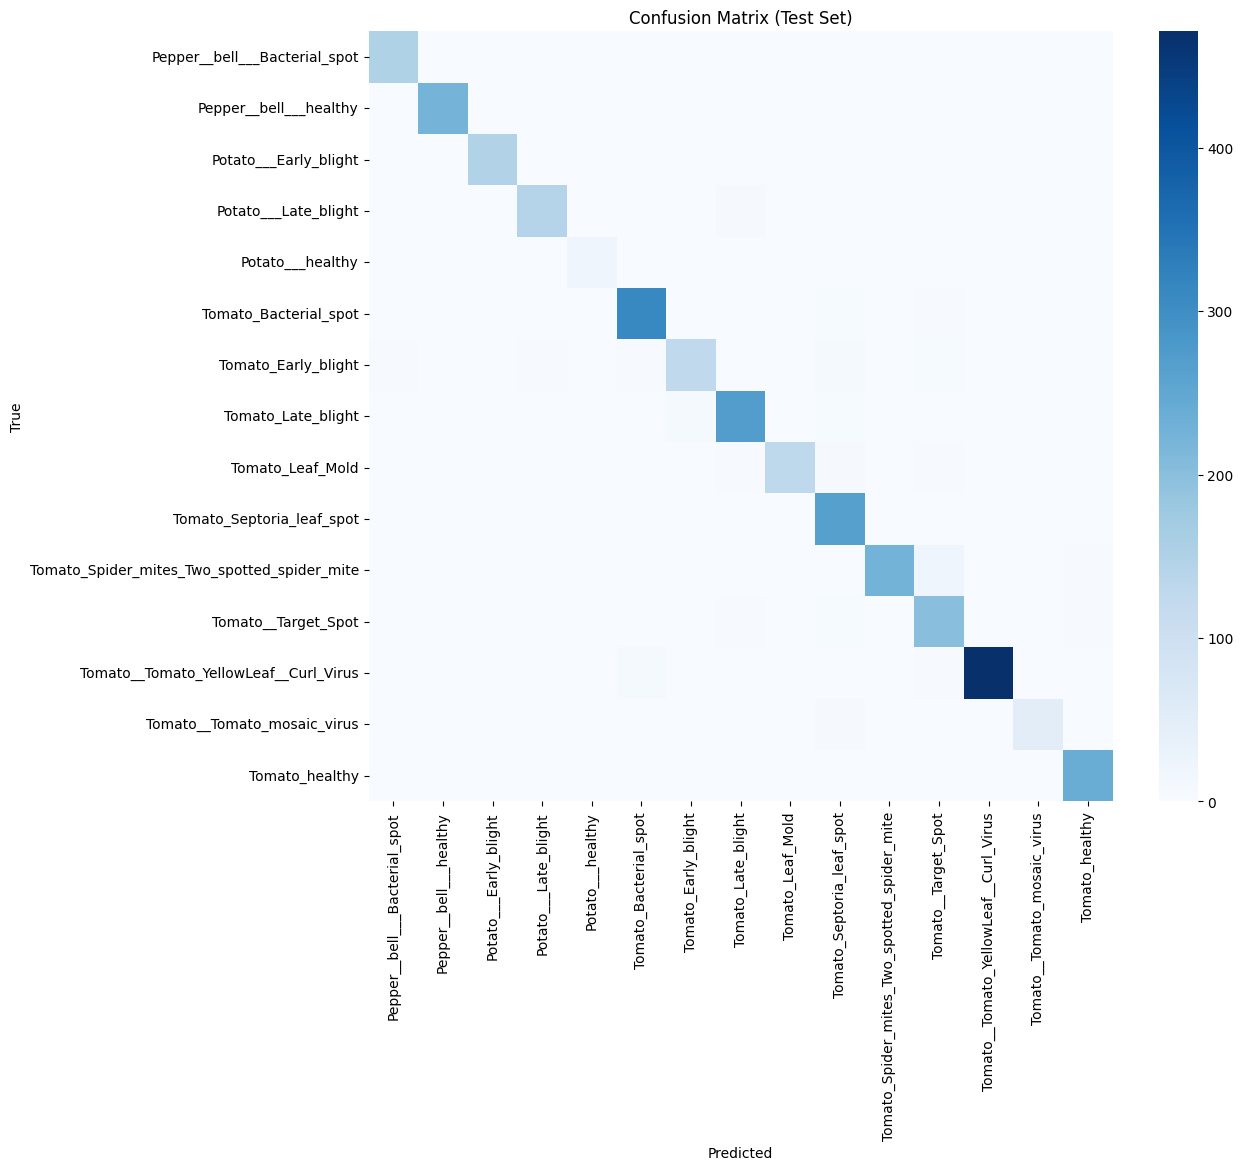

In [40]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm import tqdm


DATA_ROOT = "/content/plantvillage"
WEIGHTS   = "/content/models/mobilenetv2_finetuned_best.pt"
BATCHSIZE = 64
WORKERS   = 2


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ckpt = torch.load(WEIGHTS, map_location=device)

arch = ckpt.get("arch", "mobilenetv2")
classes = ckpt["classes"]                 # <-- saved at training time
idx_to_class = {i: c for i, c in enumerate(classes)}


tfms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])
test_ds = datasets.ImageFolder(Path(DATA_ROOT)/"test", transform=tfms)
test_dl = DataLoader(test_ds, batch_size=BATCHSIZE, shuffle=False, num_workers=WORKERS)


if arch == "mobilenetv2":
    model = models.mobilenet_v2(weights=None)
    in_feats = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_feats, len(classes))
elif arch == "resnet50":
    model = models.resnet50(weights=None)
    in_feats = model.fc.in_features
    model.fc = nn.Linear(in_feats, len(classes))
else:
    raise ValueError("Unsupported arch")

model.load_state_dict(ckpt["model_state_dict"])
model.to(device).eval()


y_true, y_pred = [], []

with torch.no_grad():
    for x, y in tqdm(test_dl, desc="Evaluating", unit="batch"):
        x, y = x.to(device), y.to(device)
        logits = model(x)
        preds = logits.argmax(1)
        y_true.extend(y.cpu().tolist())
        y_pred.extend(preds.cpu().tolist())


acc = (torch.tensor(y_true) == torch.tensor(y_pred)).float().mean().item()
print(f"\n✅ Test Accuracy: {acc:.4f}")


print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=classes))


cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=False, cmap="Blues",
            xticklabels=classes,
            yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Test Set)")
plt.show()